In [2]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
import fastai

In [3]:
from my_nn_modules import AE_big

In [4]:
torch.cuda.is_available()

True

In [5]:
#fastai.torch_core.defaults.device = 'cuda'

In [6]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


In [7]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [8]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [9]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)

In [10]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [11]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fa1f9cd9e90>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fa1f9d6dc10>;

Test: None

In [12]:
class AE_big(nn.Module):
    def __init__(self, n_features=4, dropout=0.5):
        super(AE_big, self).__init__()
        if type(dropout) is list:
            p1 = dropout[0]
            p2 = dropout[1]
            p3 = dropout[2]
            p4 = dropout[3]
            p5 = dropout[4]
            p6 = dropout[5]
            p7 = dropout[6]
        else:
            p1 = dropout
            p2 = dropout
            p3 = dropout
            p4 = dropout
            p5 = dropout
            p6 = dropout
            p7 = dropout
        self.en1 = nn.Linear(n_features, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.en2 = nn.Linear(200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.en3 = nn.Linear(100, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.en4 = nn.Linear(50, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 50)
        self.bn6 = nn.BatchNorm1d(50)
        self.de2 = nn.Linear(50, 100)
        self.bn7 = nn.BatchNorm1d(100)
        self.de3 = nn.Linear(100, 200)
        self.bn8 = nn.BatchNorm1d(200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        self.drop3 = nn.Dropout(p3)
        self.drop4 = nn.Dropout(p4)
        self.drop5 = nn.Dropout(p5)
        self.drop6 = nn.Dropout(p6)
        self.drop7 = nn.Dropout(p7)
        

    def encode(self, x):
        h1 = self.drop1(self.bn1(self.tanh(self.en1(x))))
        h2 = self.drop2(self.bn2(self.tanh(self.en2(h1))))
        h3 = self.drop3(self.bn3(self.tanh(self.en3(h2))))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.drop5(self.bn6(self.tanh(self.de1(self.drop4(self.bn5(self.tanh(x)))))))
        h6 = self.drop6(self.bn7(self.tanh(self.de2(h5))))
        h7 = self.drop7(self.bn8(self.tanh(self.de3(h6))))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        pass

In [13]:
model = AE_big(dropout=[0.001, 0.001, 0.01, 0.01, 0.01, 0.01, 0.05])

In [14]:
#def my_loss_func(input, target):
#    np.power(target - input, 2).mean()
loss_func = nn.MSELoss()
#loss_func = my_loss_func
#loss_func = model.ae_loss
#learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [15]:
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


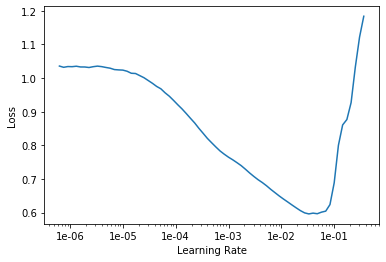

In [16]:
from fastai import train as tr
tr.lr_find(learn)
learn.recorder.plot()

In [17]:
lr = 1e-3
learn.fit(5, lr=lr, wd=0)

epoch,train_loss,valid_loss,time
0,0.027138,0.013431,00:31
1,0.021568,0.007439,00:32
2,0.020047,0.005073,00:33
3,0.020073,0.006107,00:32
4,0.019193,0.003708,00:32


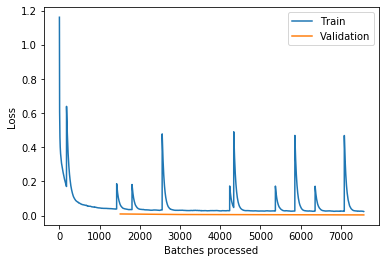

In [78]:
learn.recorder.plot_losses()

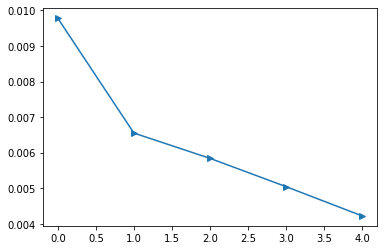

In [79]:
plt.plot(learn.recorder.val_losses, marker='>')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


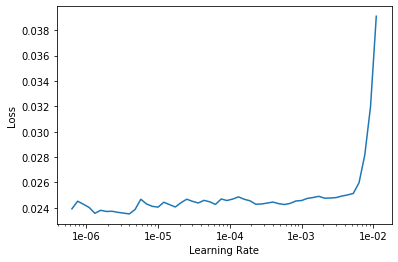

In [80]:
tr.lr_find(learn)
learn.recorder.plot()

In [81]:
lr = 1e-3
learn.fit(1, lr, wd=0)

epoch,train_loss,valid_loss,time
0,0.023977,0.003869,00:36


In [82]:
lr = 1e-3
learn.fit(5, lr, wd=0)

epoch,train_loss,valid_loss,time
0,0.025817,0.007470,00:38
1,0.028167,0.002963,00:38
2,0.023089,0.004620,00:38
3,0.080331,0.003898,00:37
4,0.021356,0.003372,00:38


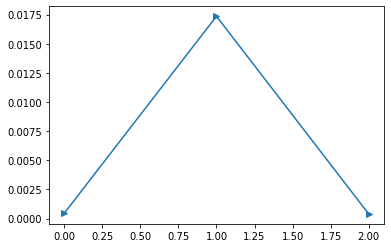

In [58]:
plt.plot(learn.recorder.val_losses, marker='>')

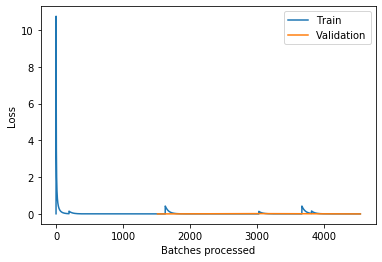

In [59]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


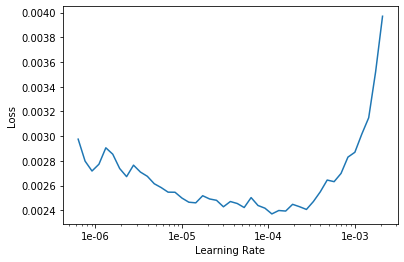

In [60]:
tr.lr_find(learn)
learn.recorder.plot()

In [62]:
lr = 1e-6
learn.fit(10, lr=lr, wd=0)

epoch,train_loss,valid_loss,time
0,0.037724,0.000423,00:36
1,0.080095,0.000445,00:37
2,0.002230,0.000381,00:36
3,0.002100,0.000366,00:36
4,0.002272,0.000429,00:36
5,0.002379,0.000399,00:36
6,0.002289,0.000410,00:36
7,0.003029,0.000357,00:36
8,0.002287,0.000358,00:37
9,0.003155,0.000351,00:36


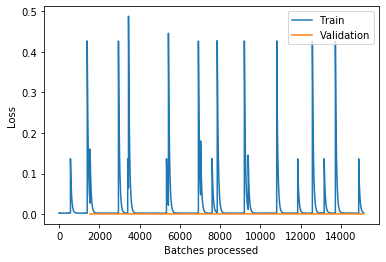

In [63]:
learn.recorder.plot_losses()

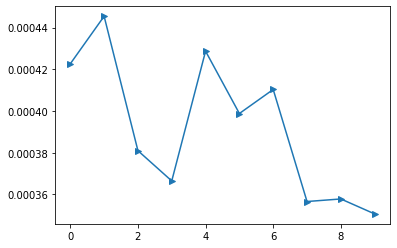

In [64]:
plt.plot(learn.recorder.val_losses, marker='>')

In [25]:
learn.data.train_ds.tensors[0][0]

tensor([ 0.6136,  0.0878, -0.8069, -0.5152])

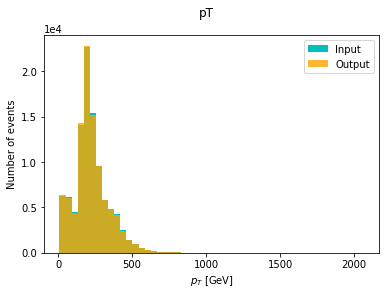

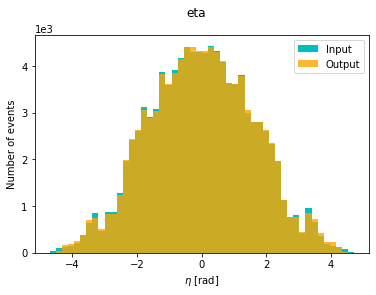

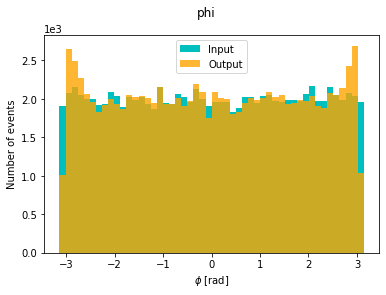

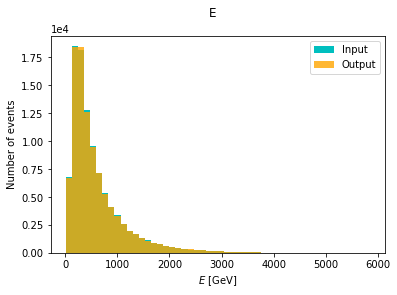

In [65]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

## Check low pT reconstruction

In [66]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train = train[train['pT']<100]
test = test[test['pT']<100]
train.head()

,pT,eta,phi,E
1739612,79.819145,4.535507,-1.185196,3722.832764
213212,74.533775,0.010658,-0.424795,74.770332
133632,73.335709,-0.998801,0.981093,113.546120
1321860,78.281624,1.674880,-2.164416,216.534836
1877459,57.215500,-3.269782,-0.657705,753.719360


In [36]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=512)

db = basic_data.DataBunch(train_dl, valid_dl)

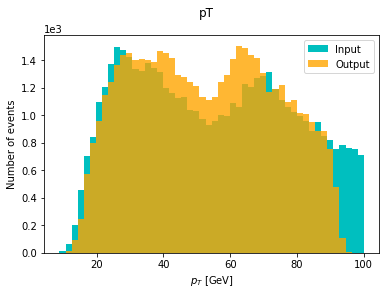

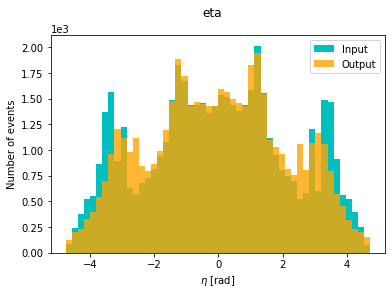

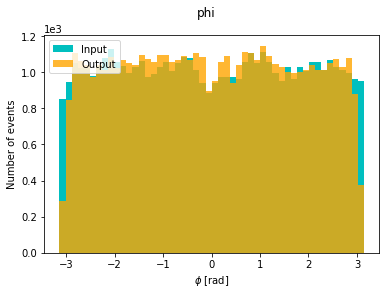

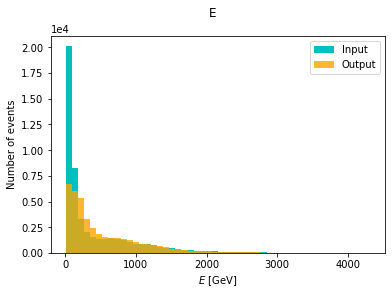

In [37]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()